# Single cell deletions

In [6]:
import sys
scripts = 'scripts'
import glob
sys.path.append(scripts)
import BLASTanalysis
import os
import importlib
import pandas as pd
blastdb = 'Database/WSN_mRNA_BLAST/WSN_mRNA.fa'
resultsDir = 'Results'
if not os.path.isdir(resultsDir):
    os.mkdir(resultsDir)
#blast variables for identifying junctions
percentIdentity = 90
wordSize = 10
gapOpen = 5
gapExtend = 2
eValue = 0.000001
outFormat = '"6 qseqid qlen qstart qend sstart send evalue sseqid qseq"'
Tenxsegments = ['human_flu_PB2_mRNA','human_flu_PB1_mRNA','human_flu_PA_mRNA',  'human_flu_HA_mRNA','human_flu_NP_mRNA','human_flu_NA_mRNA','human_flu_M_mRNA','human_flu_NS_mRNA']

#multiprocessing for mapping to speed things up a bit
from multiprocessing import Pool
numProcessors = 4
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

Pull split reads from 10x data. However, keep in mind a lot of these are going to be incorrectly annotated as they obey splice dynamics (and we will need to remove NS and M splice sites after the fact.)

In [22]:
os.system('samtools view -H Sequencing/Methanol/NS_meOH/outs/possorted_genome_bam.bam > temp.sam')
for segment in Tenxsegments:
    os.system('samtools view Sequencing/Methanol/NS_meOH/outs/possorted_genome_bam.bam ' + segment + ' | awk \'$3 ~ /mRNA/ {print}\' | awk \'($6 ~ /N/)\' >> temp.sam')
      

!samtools fasta temp.sam > temp.fa
outfile = 'Results/deletionJunctions.blastout'
infile = 'temp.fa'
arguments = ' '.join(['-db', blastdb, '-query', infile, '-perc_identity', str(percentIdentity), 
                     '-num_threads', str(numProcessors), '-word_size', str(wordSize), '-gapopen', str(gapOpen),
                     '-gapextend', str(gapExtend), '-evalue', str(eValue), '-outfmt', outFormat,
                     '-out', outfile])
!blastn $arguments

BLASTanalysis.delAnnotate('Results/deletionJunctions.blastout', 'Results/deletionJunctions_junctions.tsv', 'Database/WSN_mRNA.fa')


BLASTanalysis.delAssign('temp.sam', 'Results/deletionJunctions_junctions.tsv','Results/deletionJunctions_junctions_barcodes.tsv')
!rm -f temp.sam
!rm -f temp.fa



Remove normal M and NS splicing.



In [8]:
mSplices = [(52,741), (146,741)]
NSsplices = [(57,530)]
deletions = pd.read_csv('Results/deletionJunctions_junctions_barcodes.tsv', encoding='utf8' , sep='\t')
for splice in mSplices:
    deletions = deletions.loc[~((deletions.segment == 'M_mRNA') & (deletions.fiveprime == splice[0]) & (
                                    deletions.threeprime == splice[1]))]
for splice in NSsplices:
    deletions = deletions.loc[~((deletions.segment == 'NS_mRNA') & (deletions.fiveprime == splice[0]) & (
                                    deletions.threeprime == splice[1]))]
deletions = deletions[['barcode', 'segment', 'fiveprime','threeprime', 'count']]
deletions.to_csv('Results/deletionJunctions_junctions_barcodes.tsv', sep='\t')

Lets set some thresholds. Can subset to accepted cells in other notebook.

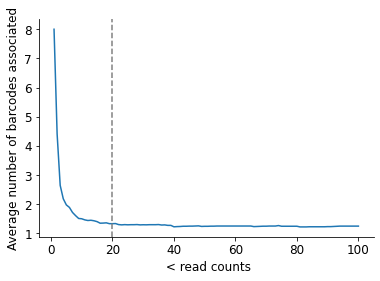

In [9]:
currNum = 1
finalNum = 100
graph = [] 
while currNum <= finalNum:
    mean = deletions[deletions['count'] >= currNum].groupby([ 'segment', 'fiveprime', 'threeprime']).count().reset_index()['count'].mean()
    currData = pd.DataFrame({'read_counts':[currNum], 'average emulsions':[mean]})
    graph += [currData]
    currNum += 1
graph=pd.concat(graph)
ax = sns.lineplot(data=graph, x="read_counts", y="average emulsions")
sns.despine()
plt.xlabel(' < read counts')
plt.ylabel('Average number of barcodes associated')
plt.axvline(x=20, c='0.5', linestyle='--')
plt.savefig('Figures/deletionthreshold.pdf', format='pdf', bbox_inches = "tight")


For each deletion it would be useful to record if full-length is likely there. This code might be a mite slow, just record the number of reads without gap immediately next to fiveprime junction (next to polyA tail)

In [5]:
deletions = deletions[deletions['count'] >= 20]
deletions = deletions.dropna()
prefix = 'human_flu_'
deletions = BLASTanalysis.adjReads(prefix, deletions, 'Sequencing/Methanol/NS_meOH/outs/possorted_genome_bam.bam')
deletions.to_csv('Results/curatedDeletions.tsv', sep='\t')